# Toxic Comment Classification

<a id='overview'></a>
## Overview
The project aims to build a multi-headed model that’s capable of detecting different types of of toxicity like threats, obscenity, insults, and identity-based hate, we will use a dataset of comments from Wikipedia’s talk page edits, collected by Kaggle. Improvements to the current model will hopefully help online discussion become more productive and respectful.


<a id='Libraries'></a>
## Packages Loading

In [1]:
import pandas as pd
import numpy as np
import re
import string
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from timeit import default_timer as timer

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from statistics import mean
from sklearn.metrics import hamming_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve
from sklearn.svm import SVC

from sklearn.metrics import roc_auc_score, confusion_matrix
import statistics
from sklearn.metrics import recall_score

from wordcloud import WordCloud
from collections import Counter

from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
test_y = pd.read_csv("test_labels.csv")

### Data Analysis

In [4]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [5]:
train.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [7]:
test_y.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,-1,-1,-1,-1,-1,-1


Notice that the training data contains 159,571 observations with 8 columns and the test data contains 153,164 observations with 2 columns.

In [8]:
train.shape

(159571, 8)

In [9]:
test.shape

(153164, 2)

Below is a plot showing the comment length frequency. As noticed, most of the comments are short with only a few comments longer than 1000 words.

<Axes: xlabel='comment_text'>

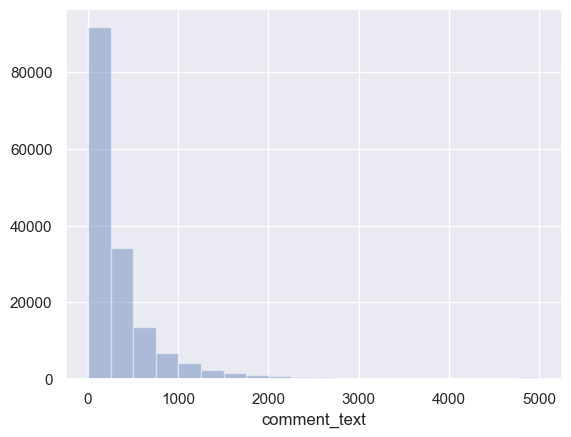

In [3]:
sns.set(color_codes=True)
comment_len = train.comment_text.str.len()
sns.distplot(comment_len, kde=False, bins=20, color="steelblue")

Further exploratory shows that label `toxic` has the most observations in the training dataset while `threat` has the least.

In [11]:
# Subsetting labels from the training data
train_labels = train[['toxic', 'severe_toxic',
                      'obscene', 'threat', 'insult', 'identity_hate']]
label_count = train_labels.sum()

<Axes: title={'center': 'Labels Frequency'}>

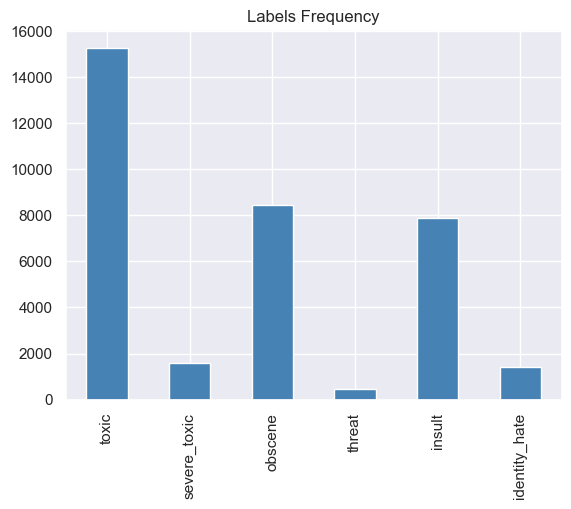

In [12]:
label_count.plot(kind='bar', title='Labels Frequency', color='steelblue')

Below is the plot for the labeled data frequency. There is significant class imbalance since majority of the comments are considered non-toxic.

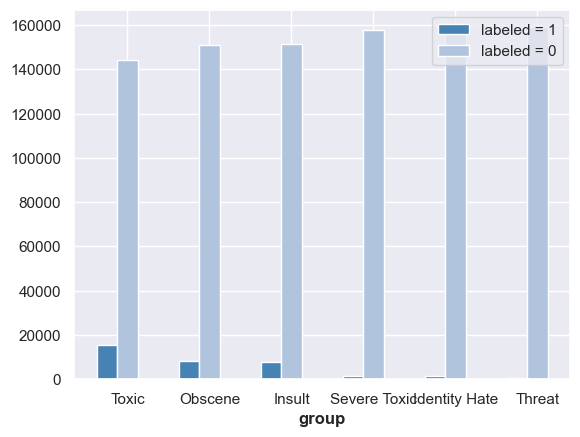

In [13]:
# Code to draw bar graph for visualising distribution of classes within each label.
barWidth = 0.25

bars1 = [sum(train['toxic'] == 1), sum(train['obscene'] == 1), sum(train['insult'] == 1), sum(train['severe_toxic'] == 1),
         sum(train['identity_hate'] == 1), sum(train['threat'] == 1)]
bars2 = [sum(train['toxic'] == 0), sum(train['obscene'] == 0), sum(train['insult'] == 0), sum(train['severe_toxic'] == 0),
         sum(train['identity_hate'] == 0), sum(train['threat'] == 0)]

r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]

plt.bar(r1, bars1, color='steelblue', width=barWidth, label='labeled = 1')
plt.bar(r2, bars2, color='lightsteelblue', width=barWidth, label='labeled = 0')

plt.xlabel('group', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], ['Toxic', 'Obscene', 'Insult', 'Severe Toxic', 'Identity Hate',
                                                       'Threat'])
plt.legend()
plt.show()

To get a better understanding of what the comments look like, below are examples of one clean (non-toxic) comment and one toxic (specifically, with label "toxic") comment.

In [14]:
# example of clean comment
train.comment_text[0]

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

In [15]:
# example of toxic comment
train[train.toxic == 1].iloc[1, 1]

'Hey... what is it..\n@ | talk .\nWhat is it... an exclusive group of some WP TALIBANS...who are good at destroying, self-appointed purist who GANG UP any one who asks them questions abt their ANTI-SOCIAL and DESTRUCTIVE (non)-contribution at WP?\n\nAsk Sityush to clean up his behavior than issue me nonsensical warnings...'

In [16]:
clean_comments = train[(train['toxic'] == 0) & (train['severe_toxic'] == 0) &
                      (train['obscene'] == 0) & (train['threat'] == 0) &
                      (train['insult'] == 0) & (train['identity_hate'] == 0)]

In [17]:
num_clean_comments = clean_comments.shape[0]
num_clean_comments

143346

In [18]:
# Percent of bad comments
num_bad_comments = train.shape[0] - num_clean_comments
percent = (num_bad_comments / train.shape[0]) * 100
print("Percent of bad comments: ", percent)

Percent of bad comments:  10.167887648758233


It might be a great practice to see which labels are likely to appear together with a comment.

<Axes: >

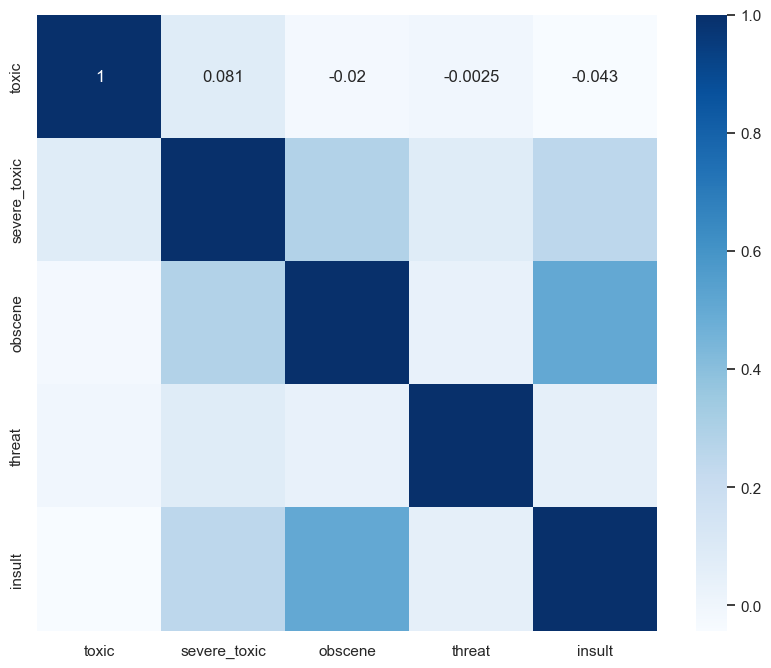

In [19]:
# Cross correlation matrix across labels
rowsums = train.iloc[:, 2:].sum(axis=1)
temp = train.iloc[:, 2:-1]
train_corr = temp[rowsums > 0]
corr = train_corr.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot=True, cmap="Blues")

As seen in the cross-correlation matrix, there is a high chance of obscene comments to be insulting.

In order to get an idea of what are the words that contribute the most to different labels, we write a function to generate word clouds. The function takes in a parameter label (i.e., toxic, insult, threat, etc)

In [20]:
def W_Cloud(token):
    """
    Visualize the most common words contributing to the token.
    """
    threat_context = train[train[token] == 1]
    threat_text = threat_context.comment_text
    neg_text = pd.Series(threat_text).str.cat(sep=' ')
    wordcloud = WordCloud(width=1600, height=800,
                          max_font_size=200).generate(neg_text)

    plt.figure(figsize=(15, 10))
    plt.imshow(wordcloud.recolor(colormap="Blues"), interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Most common words assosiated with {token} comment", size=20)
    plt.show()

Choose a class to visualize the most common words contributing to the class: toxic


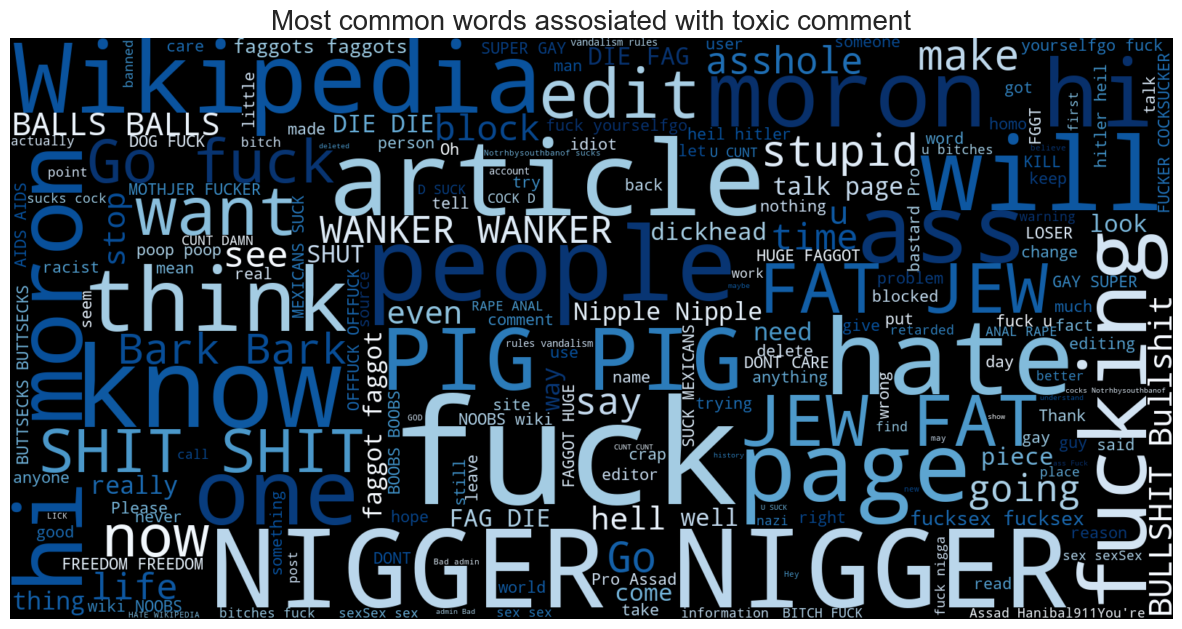

In [21]:
# interactive visual : enter the label name.
token = input(
    'Choose a class to visualize the most common words contributing to the class:')
W_Cloud(token.lower())

<a id='Feature-engineering'></a>
## Feature-engineering

Before fitting models, we need to break down the sentence into unique words by tokenizing the comments. In the `tokenize()` function, we remove punctuations and special characters. We also filtered out non-ascii characters after observing the results of feature engineering. We then lemmatize the comments and filter out comments with length below 3. Besides lemmatization, we also tried stemming but did not get a better result.

In [22]:
test_labels = ["toxic", "severe_toxic", "obscene",
               "threat", "insult", "identity_hate"]

In [23]:
def tokenize(text):
    '''
    Tokenize text and return a non-unique list of tokenized words found in the text.
    Normalize to lowercase, strip punctuation, remove stop words, filter non-ascii characters.
    Lemmatize the words and lastly drop words of length < 3.
    '''
    text = text.lower()
    regex = re.compile('[' + re.escape(string.punctuation) + '0-9\\r\\t\\n]')
    nopunct = regex.sub(" ", text)
    words = nopunct.split(' ')
    # remove any non ascii
    words = [word.encode('ascii', 'ignore').decode('ascii') for word in words]
    lmtzr = WordNetLemmatizer()
    words = [lmtzr.lemmatize(w) for w in words]
    words = [w for w in words if len(w) > 2]
    return words

#### Benchmarking Different Vectorizer

We determined to use TFIDF to scale down the impact of tokens that occur very frequently in a given corpus and that are hence empirically less informative than features that occur in a small fraction of the training corpus.

Besides TFIDF, we also tried CountVectorizer. However, it is not performing as well as TFIDF. The TfidfVectorizer is actually CountVectorizer followed by TfidfTransformer. TfidfTransformer transforms a count matrix to a normalized Term-Frequency or TermFrequency-InverseDocumentFrequency representation. The goal of using tf-idf instead of the raw frequencies of occurrence of a token in a given document is to scale down the impact of tokens that occur very frequently in a given corpus and that are hence empirically less informative than features that occur in a small fraction of the training corpus. That's why we can improve the accuracy here.

For example: Since this corpus consists of data from the Wikipedia's talk page edits, the words such as wiki, Wikipedia, edit, page are very common. But for our classification purposes they do not provide us useful information and that should probably be the reason why TFIDF worked better than CountVectorizer.

After the transformation, we can take a look at some of the features below.

<a id='Modeling'></a>
## Modeling and Evaluation

### Baseline Model

We choose Naive Bayes as our baseline model, specifically Multinomial Naive Bayes.

Also, we want to compare between different models, especially models that perform well in text classification. Thus, we choose to compare Multinomial Naive Bayes with Logistic Regression and Linear Support Vector Machine.

In [ ]:
vector1 = TfidfVectorizer(ngram_range=(1, 1), analyzer='word',
                         tokenizer=tokenize, stop_words='english',
                         strip_accents='unicode', use_idf=1, min_df=10)

t = train.head(20000)
tt = test.head(20000)

X_train = vector.fit_transform(t['comment_text'])
X_test = vector.transform(tt['comment_text'])

In [ ]:
model = SVC(kernel='linear')
methods = pd.DataFrame(cross_validation_score(model, X_train, t))

In [ ]:
methods

,0,1,2,3
0,SVC,toxic,0.524404,0.665404
1,SVC,severe_toxic,0.000000,0.000000
2,SVC,obscene,0.626739,0.737634
3,SVC,threat,0.000000,0.000000
4,SVC,insult,0.497487,0.605514
5,SVC,identity_hate,0.093860,0.164509


In [ ]:
from sklearn.ensemble import RandomForestClassifier
modelR = RandomForestClassifier(n_estimators=100)
methodsR = pd.DataFrame(cross_validation_score(modelR, X_train, t))
methodsR

,0,1,2,3
0,RandomForestClassifier,toxic,0.562424,0.664204
1,RandomForestClassifier,severe_toxic,0.066996,0.122467
2,RandomForestClassifier,obscene,0.666641,0.742095
3,RandomForestClassifier,threat,0.000000,0.000000
4,RandomForestClassifier,insult,0.526880,0.603646
5,RandomForestClassifier,identity_hate,0.121637,0.196580


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)
methodsk = pd.DataFrame(cross_validation_score(knn, X_train, t))
methodsk

,0,1,2,3
0,KNeighborsClassifier,toxic,0.342112,0.481396
1,KNeighborsClassifier,severe_toxic,0.171937,0.243504
2,KNeighborsClassifier,obscene,0.403020,0.547090
3,KNeighborsClassifier,threat,0.000000,0.000000
4,KNeighborsClassifier,insult,0.332981,0.451692
5,KNeighborsClassifier,identity_hate,0.198830,0.275721


In [ ]:
from sklearn.cluster import KMeans


kmeans = KMeans(n_clusters=2)
methodskm = pd.DataFrame(cross_validation_score(kmeans, X_train, t))
methodskm

,0,1,2,3
0,KMeans,toxic,0.417985,0.087695
1,KMeans,severe_toxic,0.045133,0.009039
2,KMeans,obscene,0.408364,0.039840
3,KMeans,threat,0.185278,0.005551
4,KMeans,insult,0.327721,0.052742
5,KMeans,identity_hate,0.286688,0.004532


Our main metric for measuring model performance is F1-score, since we have 6 labels, the F1-score would be the average of 6 labels. We will also take other metrics into consideration while evaluating models, e.g, Hamming loss and recall.

<a id='cv'></a>
### Cross Validation

In [24]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Darahas\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [25]:
vector = TfidfVectorizer(max_features=1000,ngram_range=(1, 1), analyzer='word',
                         tokenizer=tokenize, stop_words='english',
                         strip_accents='unicode', use_idf=1, min_df=10)
X_train = vector.fit_transform(train['comment_text'])
X_test = vector.transform(test['comment_text'])

In [26]:
vector.get_feature_names_out()[0:20]

array(['able', 'absolutely', 'abuse', 'academic', 'accept', 'acceptable',
       'accepted', 'access', 'according', 'account', 'accurate',
       'accusation', 'act', 'action', 'active', 'activity', 'actual',
       'actually', 'add', 'added'], dtype=object)

We use cross Validation to compare between the baseline model and the other two models that we have chosen (LogisticRegression and LinearSVC).

In [27]:
# Creating classifiers with default parameters initially.
clf0 = BernoulliNB()
clf1 = MultinomialNB()
clf2 = LogisticRegression()
clf3 = LinearSVC()

In [28]:
def cross_validation_score(classifier, X_train, y_train):
    '''
    Iterate though each label and return the cross validation F1 and Recall score
    '''
    methods = []
    name = classifier.__class__.__name__.split('.')[-1]

    for label in test_labels:
        recall = cross_val_score(
            classifier, X_train, y_train[label], cv=10, scoring='recall')
        f1 = cross_val_score(classifier, X_train,
                             y_train[label], cv=10, scoring='f1')
        methods.append([name, label, recall.mean(), f1.mean()])

    return methods

In [29]:
# Calculating the cross validation F1 and Recall score for our 4 baseline models.
methods_cv = pd.DataFrame(cross_validation_score(clf0, X_train, train))
methods1_cv = pd.DataFrame(cross_validation_score(clf1, X_train, train))
methods2_cv = pd.DataFrame(cross_validation_score(clf2, X_train, train))
methods3_cv = pd.DataFrame(cross_validation_score(clf3, X_train, train))

In [30]:
# Creating a dataframe to show summary of results.
methods_cv = pd.concat([methods_cv,methods1_cv, methods2_cv, methods3_cv])
methods_cv.columns = ['Model', 'Label', 'Recall', 'F1']
meth_cv = methods_cv.reset_index()
meth_cv[['Model', 'Label', 'Recall', 'F1']]

,Model,Label,Recall,F1
0,BernoulliNB,toxic,0.828887,0.375861
1,BernoulliNB,severe_toxic,0.915987,0.123323
2,BernoulliNB,obscene,0.863653,0.298076
3,BernoulliNB,threat,0.742420,0.119893
4,BernoulliNB,insult,0.847537,0.274518
5,BernoulliNB,identity_hate,0.815638,0.136079
6,MultinomialNB,toxic,0.452856,0.612089
7,MultinomialNB,severe_toxic,0.292744,0.368426
8,MultinomialNB,obscene,0.536394,0.676391
9,MultinomialNB,threat,0.021055,0.040091


Based on the cross validation above, we noticed that overall, the linear SVC model and Logistic Regression model perform better. As a baseline model, Multinomial Naive Bayes does not perform well, especially for the `threat` label and `identity_hate` label because these two labels have the least number of observations.

Now we want to see how these three models perform on the actual prediction - the test dataset.

### ⚔ Modeling and Evaluation

In [31]:
def score(classifier, X_train, y_train, X_test, y_test):
    """
    Calculate Hamming-loss, F1, Recall for each label on test dataset.
    """
    methods = []
    hloss = []
    name = classifier.__class__.__name__.split('.')[-1]
    predict_df = pd.DataFrame()
    predict_df['id'] = test_y['id']

    for label in test_labels:
        classifier.fit(X_train, y_train[label])
        predicted = classifier.predict(X_test)

        predict_df[label] = predicted

        recall = recall_score(y_test[y_test[label] != -1][label],
                              predicted[y_test[label] != -1],
                              average="weighted")
        f1 = f1_score(y_test[y_test[label] != -1][label],
                      predicted[y_test[label] != -1],
                      average="weighted")

        conf_mat = confusion_matrix(y_test[y_test[label] != -1][label],
                                    predicted[y_test[label] != -1])

        methods.append([name, label, recall, f1, conf_mat])

    hamming_loss_score = hamming_loss(test_y[test_y['toxic'] != -1].iloc[:, 1:7],
                                      predict_df[test_y['toxic'] != -1].iloc[:, 1:7])
    hloss.append([name, hamming_loss_score])

    return hloss, methods

In [32]:
# Calculating the Hamming-loss F1 and Recall score for our 3 baseline models.

h0, methods0 = score(clf0, X_train, train, X_test, test_y)
h1, methods1 = score(clf1, X_train, train, X_test, test_y)
h2, methods2 = score(clf2, X_train, train, X_test, test_y)
h3, methods3 = score(clf3, X_train, train, X_test, test_y)

In [33]:
# Creating a dataframe to show summary of results.

methods0 = pd.DataFrame(methods0)
methods1 = pd.DataFrame(methods1)
methods2 = pd.DataFrame(methods2)
methods3 = pd.DataFrame(methods3)
methods = pd.concat([methods0,methods1, methods2, methods3])
methods.columns = ['Model', 'Label', 'Recall', 'F1', 'Confusion_Matrix']
meth = methods.reset_index()
meth[['Model', 'Label', 'Recall', 'F1']]

,Model,Label,Recall,F1
0,BernoulliNB,toxic,0.688252,0.752619
1,BernoulliNB,severe_toxic,0.796258,0.881109
2,BernoulliNB,obscene,0.726187,0.799135
3,BernoulliNB,threat,0.949186,0.970978
4,BernoulliNB,insult,0.719732,0.796730
5,BernoulliNB,identity_hate,0.840430,0.903430
6,MultinomialNB,toxic,0.936853,0.932143
7,MultinomialNB,severe_toxic,0.992701,0.992829
8,MultinomialNB,obscene,0.963753,0.960221
9,MultinomialNB,threat,0.996718,0.995242


In [34]:
test_y_s = test_y.head(20000)
hs, methodss = score(model, X_train, t, X_test, test_y_s)
hr, methodsr = score(modelR, X_train, t, X_test, test_y_s)
hkn, methodskn = score(knn, X_train, t, X_test, test_y_s)
# hkm, methodskm = score(kmeans, X_train, t, X_test, test_y_s)

NameError: name 'model' is not defined

In [ ]:
# Creating a dataframe to show summary of results.
methodss = pd.DataFrame(methodss)
methodsr = pd.DataFrame(methodsr)
methodskn = pd.DataFrame(methodskn)
# methodskm = pd.DataFrame(methodskm)
methods = pd.concat([methodss, methodsr, methodskn])
methods.columns = ['Model', 'Label', 'Recall', 'F1', 'Confusion_Matrix']
meth = methods.reset_index()
meth[['Model', 'Label', 'Recall', 'F1']]

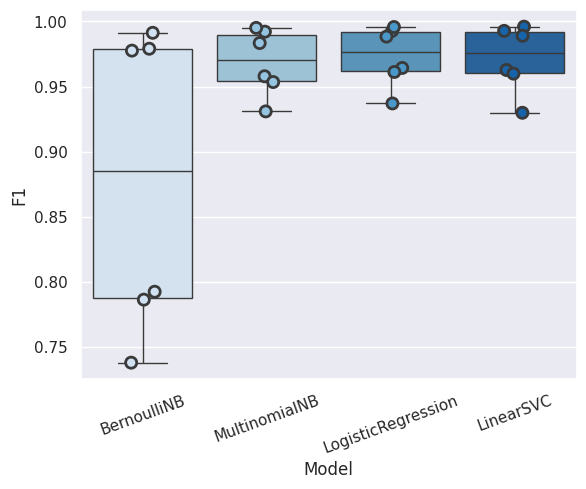

In [ ]:
# Visualizing F1 score results through box-plot.
ax = sns.boxplot(x='Model', y='F1', data=methods, palette="Blues")
sns.stripplot(x='Model', y='F1', data=methods,
              size=8, jitter=True, edgecolor="gray", linewidth=2, palette="Blues")
ax.set_xticklabels(ax.get_xticklabels(), rotation=20)

plt.show()

Above are the result table and plot showing a comparison between these different models after training them and see how these models perform on the test data.

Notice that Muninomial Naive Bayes does not perform as well as the other two models while Linear SVC in general out performs the others based on F1 score.

### Visualzing performance till now for each classifier across each category

Plot for Multinomial Naive Bayes regression


<Axes: title={'center': 'Metrics'}, xlabel='Label'>

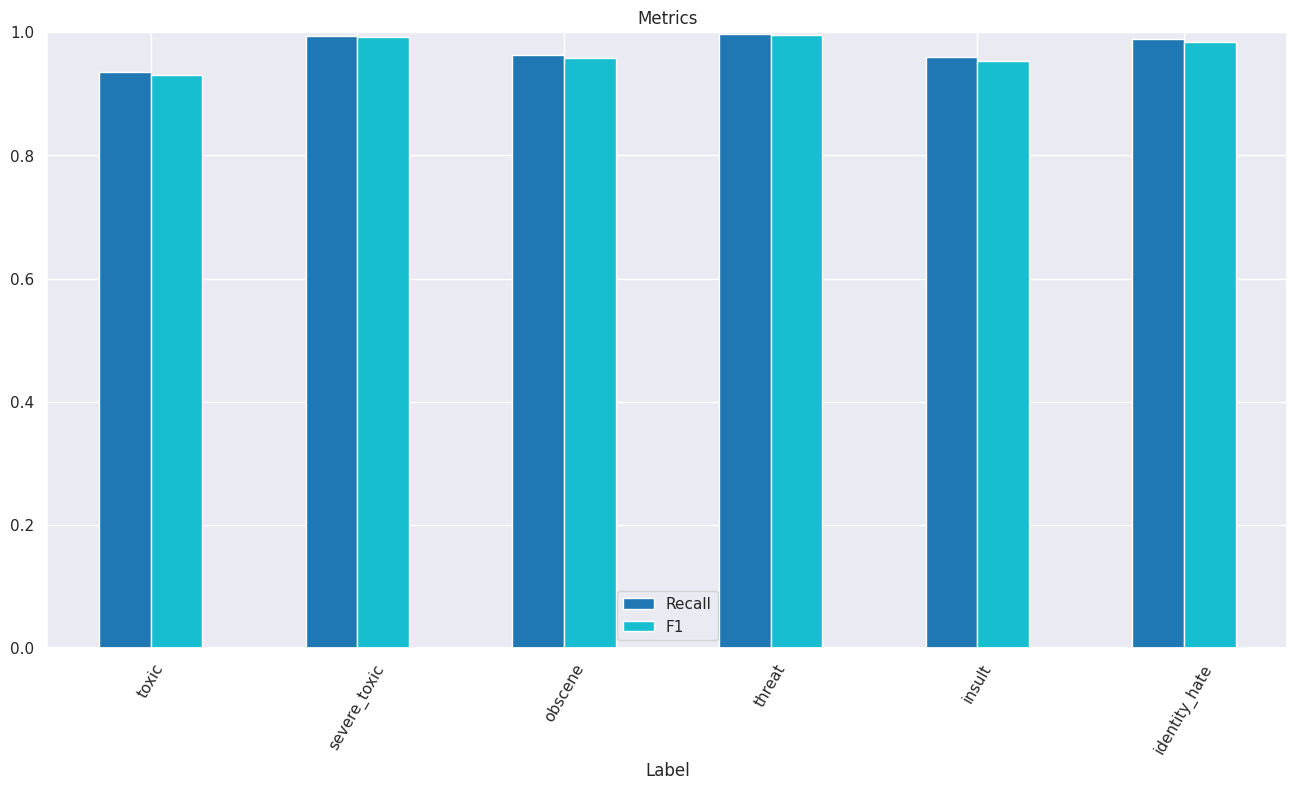

In [ ]:
# Code to create bar graph of F1 and Recall across each label for Multinomial Naive Bayes
print("Plot for Multinomial Naive Bayes regression")
m2 = methods[methods.Model == 'MultinomialNB']

m2.set_index(["Label"], inplace=True)
%matplotlib inline
m2.plot(figsize=(16, 8), kind='bar', title='Metrics',
        rot=60, ylim=(0.0, 1), colormap='tab10')

Plot for Logistic regression


<Axes: title={'center': 'Metrics'}, xlabel='Label'>

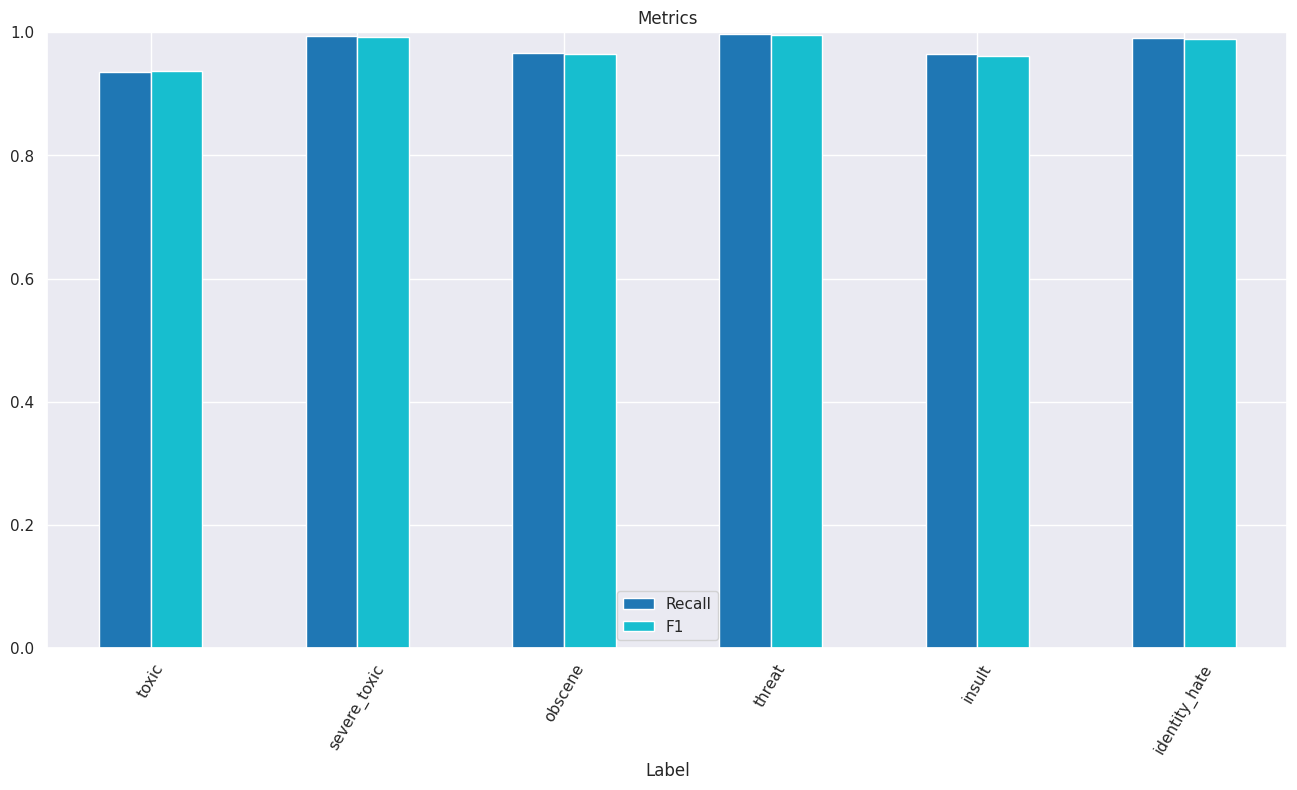

In [ ]:
# Code to create bar graph of F1 and Recall across each label for Logistic regression
print("Plot for Logistic regression")
m2 = methods[methods.Model == 'LogisticRegression']

m2.set_index(["Label"], inplace=True)
%matplotlib inline
m2.plot(figsize=(16, 8), kind='bar', title='Metrics',
        rot=60, ylim=(0.0, 1), colormap='tab10')

Plot for Linear SVC


<Axes: title={'center': 'Metrics'}, xlabel='Label'>

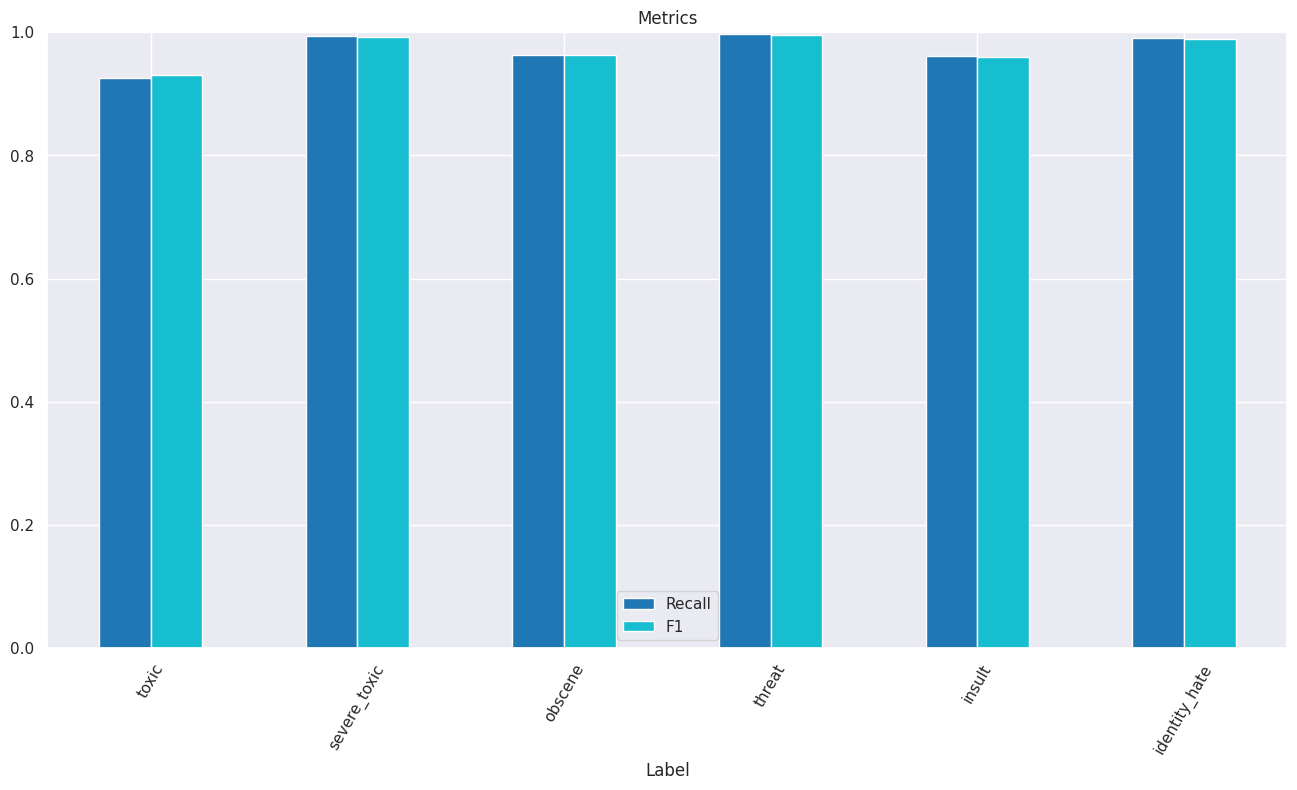

In [ ]:
# Code to create bar graph of F1 and Recall across each label for Linear SVC
print("Plot for Linear SVC")
m2 = methods[methods.Model == 'LinearSVC']

m2.set_index(["Label"], inplace=True)
%matplotlib inline
m2.plot(figsize=(16, 8), kind='bar', title='Metrics',
        rot=60, ylim=(0.0, 1), colormap='tab10')

<a id='model-comparison'></a>
###  Confusion Matrix visualization

In [ ]:
def drawConfusionMatrix(cm):
    """
    Plot Confusion matrix of input cm.
    """
    cm = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
    ax = plt.axes()
    sns.heatmap(cm,
                annot=True,
                annot_kws={"size": 16},
                cmap="Blues",
                fmt='.2f',
                linewidths=2,
                linecolor='steelblue',
                xticklabels=("Non-toxic", "Toxic"),
                yticklabels=("Non-toxic", "Toxic"))

    plt.ylabel('True', fontsize=18)
    plt.xlabel('Predicted', fontsize=18)
    plt.show()

In [ ]:
def Matrix(label):
    print(f"*************** {label} labelling ***************")
    labels = {"toxic": 0, "severe_toxic": 1, "obscene": 2,
              "threat": 3, "insult": 4, "identity_hate": 5}

    pos = labels[label]
    for i in range(pos, len(meth), 6):
        print()
        print(f"****  {meth['Model'][i]}  ***")
        cm = meth['Confusion_Matrix'][i]
        drawConfusionMatrix(cm)

Choose a class for the Confusion Matrix: insult
*************** insult labelling ***************

****  BernoulliNB  ***


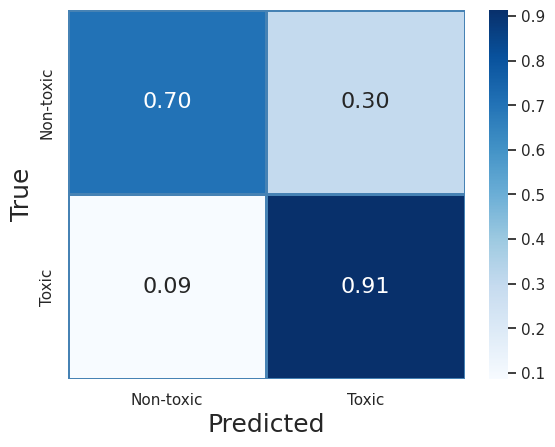


****  MultinomialNB  ***


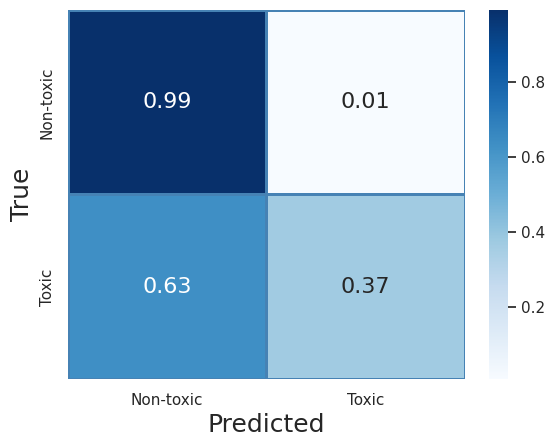


****  LogisticRegression  ***


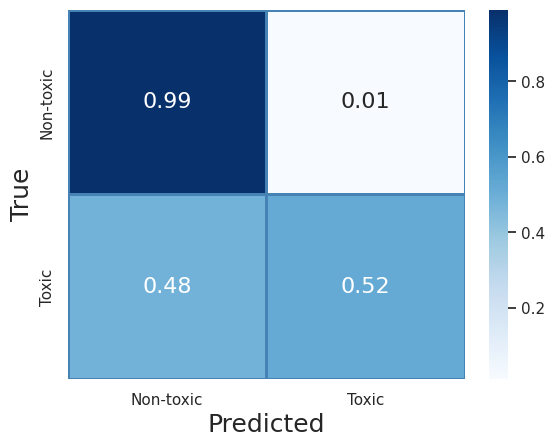


****  LinearSVC  ***


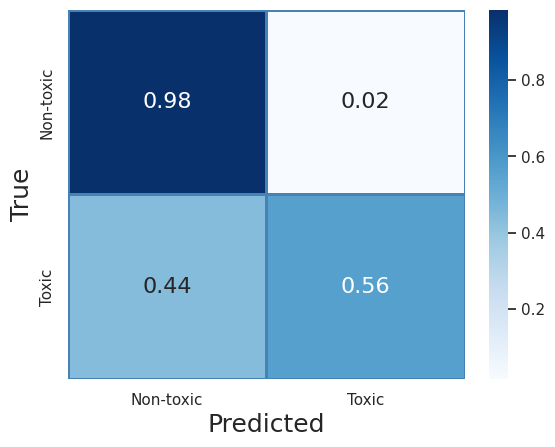

In [ ]:
token = input('Choose a class for the Confusion Matrix: ')
Matrix(token.lower())

Based on the above comparison, we could say that for these three models with default settings, **LinearSVC performs better than anyone for 'toxic' label .**




### Aggregated Hamming Loss Score


In [ ]:
# Creating a dataframe to summarize Hamming-loss
hl0_df = pd.DataFrame(h0)
hl1_df = pd.DataFrame(h1)
hl2_df = pd.DataFrame(h2)
hl3_df = pd.DataFrame(h3)

In [ ]:
hammingloss = pd.concat([hl0_df,hl1_df, hl2_df, hl3_df])
hammingloss.columns = ['Model', 'Hamming_Loss']
hl = hammingloss.reset_index()
hl[['Model', 'Hamming_Loss']]

,Model,Hamming_Loss
0,BernoulliNB,0.163147
1,MultinomialNB,0.026939
2,LogisticRegression,0.025670
3,LinearSVC,0.028476


Across all models , **Logistic Regression** is doing a great job overall since it has the lowest percentage of incorrect labels.

Notice that after adjusting `class_weight`, we are getting way better results than the basic models. LinearSVC outperforms LogisticRegression by approximately 1%.

We tried 3 popular tree-based boosting models, and make a comparison for those models.

Analyzing the words misclassified by Logistic Classifier. Checking for 'toxic' label


In [ ]:
label = 'toxic'
lr = LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
               intercept_scaling=1, loss='squared_hinge', max_iter=1000,
               multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
               verbose=0)
lr.fit(X_train, train[label])
Toxic_LR = lr.predict(X_test)
test_combined = pd.concat([test, test_y], axis=1)

In [ ]:
commentCheck = test_combined[(test_combined.toxic == 1) & (
    Toxic_LR == 0)].comment_text
commentCheck.shape

(1347,)

- Misclassified 1347 as non-toxic which were actually toxic

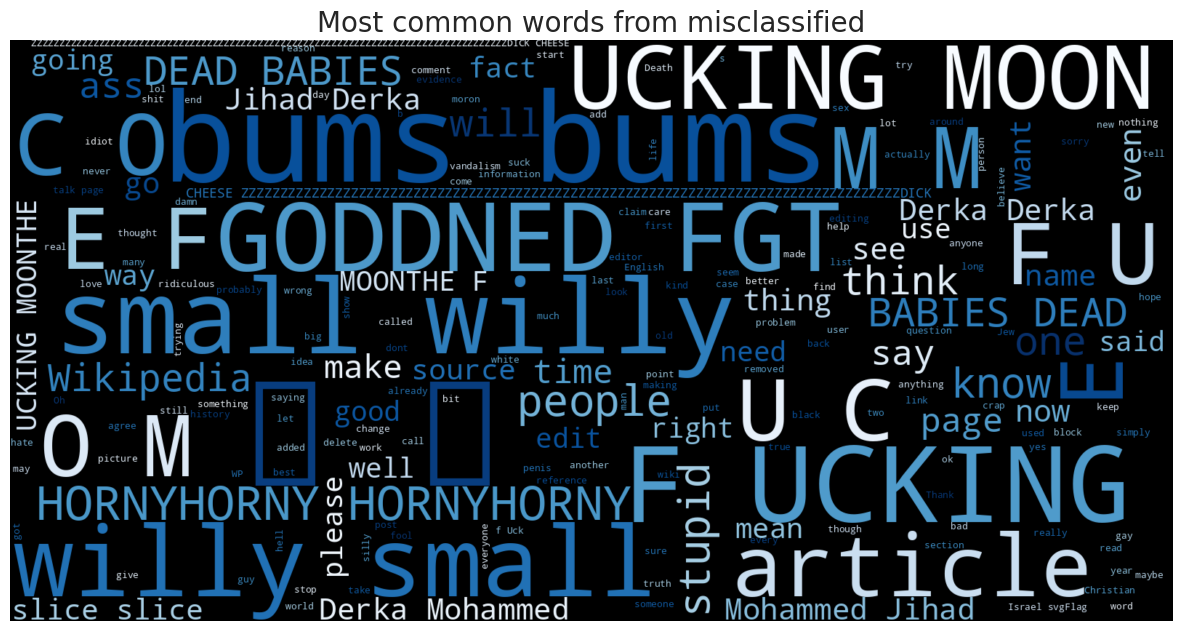

In [ ]:
# extract wrongly classified comments
commentCheck = test_combined[(test_combined.toxic == 1) & (
    Toxic_LR == 0)].comment_text

neg_Check = pd.Series(commentCheck).str.cat(sep=' ')
wordcloud = WordCloud(width=1600, height=800,
                      max_font_size=200).generate(neg_Check)
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud.recolor(colormap="Blues"), interpolation='bilinear')
plt.axis("off")
plt.title("Most common words from misclassified", size=20)
plt.show()

- We want to analyze why the model couldn't recognize these words. Were they not present in the training set?
- In order to analyze, we first need to pass these raw comment strings through same tokenizer and check the common tokens.

`ucking` is a common word in the test set and it seems our classifier hasnt learnt to classify it as toxic. Let's check how frequent was this word in the training data.

It is interesting to note that this token wasn't common in our training set. That explains why our model couldn't learn it.
It also gives us some food for thought on how we can improve our model further.

Let's see the features and whether this word has a high feature importance.

### 👓 Visual check how logistic learns

In [ ]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Plot learning rate curve for the estimator with title, training data as X,
    labels as y.
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_sizes, train_scores, test_scores = learning_curve(estimator,
                                                            X, y, train_sizes=train_sizes, cv=cv, n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="steelblue",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="olive",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

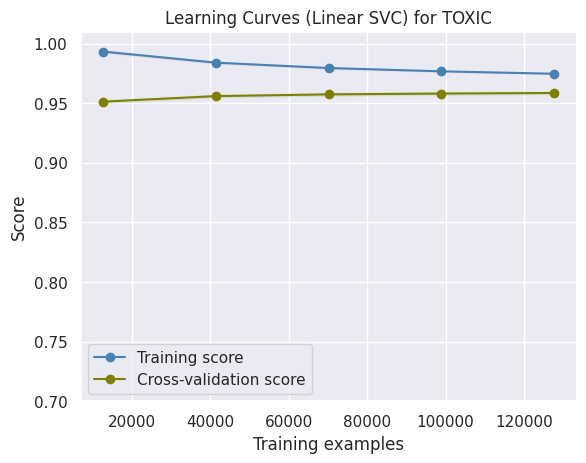

In [ ]:
title = "Learning Curves (Linear SVC) for TOXIC"
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
estimator = LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
                      intercept_scaling=1, loss='squared_hinge', max_iter=1000,
                      multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
                      verbose=0)
plot_learning_curve(estimator, title, X_train,
                    train['toxic'], ylim=(0.7, 1.01), cv=cv, n_jobs=4)

## Future Improvements

 - Try more ways of vectorizing text data.
 - Go deeper on feature engineering : Spelling corrector, Sentiment scores, n-grams, etc.
 - Advanced models (e.g., lightgbm).
 - Advanced Ensemble model (e.g., stacking).
 - Deep learning model (e.g., LSTM).
 - Advanced hyperparameter tuning techniques (e.g., Bayesian Optimization).